### 0. Imports and Setups

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque, defaultdict
import collections
import pickle
from tqdm import tqdm

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import time

# for plotting graphs
import matplotlib.pyplot as plt


In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/Env.py' .
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/TM.npy' .

In [31]:
# The long training time is due to the fact of the current version of Tensorflow (v2) 
# which keras uses as it backend. We could switch back to v1 Tensorflow, the training time reduces significantly.
from keras import backend as K
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
jobs = 8 # Play around with this number
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

In [32]:

# Import the environment
from Env import CabDriver

#### 1. Defining Time Matrix

In [33]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [34]:
Time_matrix.shape

(5, 5, 24, 7)

In [35]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


**Observation**
- The time matrix is 4 dimensional - start_location, end_location, hour of day, day of the week
-  The max time taken between 2 consequtive points is 11 hours, time can increase by a day

###2.  Defining the MDP Environment

In [36]:
env = CabDriver()
action_space, state_space, state = env.reset()

In [37]:
action_space

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [38]:
state_space

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 0, 3],
 [0, 0, 4],
 [0, 0, 5],
 [0, 0, 6],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 2],
 [0, 1, 3],
 [0, 1, 4],
 [0, 1, 5],
 [0, 1, 6],
 [0, 2, 0],
 [0, 2, 1],
 [0, 2, 2],
 [0, 2, 3],
 [0, 2, 4],
 [0, 2, 5],
 [0, 2, 6],
 [0, 3, 0],
 [0, 3, 1],
 [0, 3, 2],
 [0, 3, 3],
 [0, 3, 4],
 [0, 3, 5],
 [0, 3, 6],
 [0, 4, 0],
 [0, 4, 1],
 [0, 4, 2],
 [0, 4, 3],
 [0, 4, 4],
 [0, 4, 5],
 [0, 4, 6],
 [0, 5, 0],
 [0, 5, 1],
 [0, 5, 2],
 [0, 5, 3],
 [0, 5, 4],
 [0, 5, 5],
 [0, 5, 6],
 [0, 6, 0],
 [0, 6, 1],
 [0, 6, 2],
 [0, 6, 3],
 [0, 6, 4],
 [0, 6, 5],
 [0, 6, 6],
 [0, 7, 0],
 [0, 7, 1],
 [0, 7, 2],
 [0, 7, 3],
 [0, 7, 4],
 [0, 7, 5],
 [0, 7, 6],
 [0, 8, 0],
 [0, 8, 1],
 [0, 8, 2],
 [0, 8, 3],
 [0, 8, 4],
 [0, 8, 5],
 [0, 8, 6],
 [0, 9, 0],
 [0, 9, 1],
 [0, 9, 2],
 [0, 9, 3],
 [0, 9, 4],
 [0, 9, 5],
 [0, 9, 6],
 [0, 10, 0],
 [0, 10, 1],
 [0, 10, 2],
 [0, 10, 3],
 [0, 10, 4],
 [0, 10, 5],
 [0, 10, 6],
 [0, 11, 0],
 [0, 11, 1],
 [0, 11, 2],
 [0, 11, 3],
 [0, 11, 4],
 [0,

**Observation**
- The state spaces are correctly initialized into a Vector [State, Day, Hour]

In [39]:
print ("The randomly initialized state is {}".format(state))

The randomly initialized state is [0, 10, 3]


In [40]:
#env.self_state_init_for_test([0,17,5])
env.requests(state)

([7, 17, 11, 20, 0], [(1, 3), (4, 0), (2, 3), (4, 3), (0, 0)])

**Observation** 
- Returns the correct randomised action, and corresponding index, based on the traffic (Poisson Random Variable) for the location

In [41]:
Time_matrix[4,3,17,5]

6.0

In [42]:
env.next_state_func(state,[4,3],Time_matrix)

([3, 18, 3], 0, 2.0, 6.0)

In [43]:
state = [0,1,2]
env.state_encod_arch1(state)

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

**Observation** 
- The universal state space and action space look properly initialized
- The current state is randomly initialized
- The request function returns random states based on Traffic
- The next state is being generated, and encoded correctly

#### 2. Utilties

In [44]:

#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


##### Epsilon- Greedy strategy

Way of selecting random actions with uniform distribution.
We can either select random action with epsilon probability or
We can select an action with 1-epsilon probably which will give maximum reward in a given state

Check epsilon decay over episodes

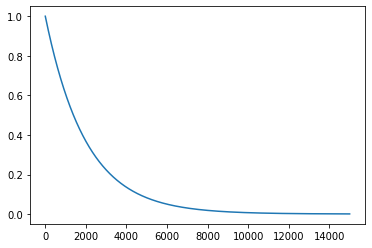

In [45]:
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = -0.0005
time_tic = np.arange(0,15000)
epsilon = []

#Number of episodes for training
for i in time_tic:
     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(time_tic, epsilon)
plt.show()


##### Initialize Tracking States

In [46]:
def initialize_tracking_states():
    state_action_pair = [((0, 0, 0), (0, 1)),
                         ((0, 1, 1), (3, 4)),
                         ((1, 2, 2), (0, 2)),
                         ((1, 2, 2), (2, 3)),
                         ((2, 3, 3), (2, 1)),
                         ((2, 3, 3), (3, 4)),
                         ((3, 4, 4), (3, 0)), 
                         ((4, 4, 4), (1, 0)),
                         ((4, 5, 5), (0, 1)),
                         ((4, 5, 5), (1, 2))]

    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = defaultdict()
        tracked_states[state][action] = list()




##### Persist q-values corresponding for tracked states

In [47]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
        q_predict = driver.model.predict(encoded_state)
        

        for action in tracked_states[state].keys():            
            action_index = list(
                filter(
                    lambda x: action == env.action_space[x],
                    range(0, len(env.action_space))))[0]
            q_value = q_predict[0][action_index]            
            tracked_states[state][action].append(q_value)

## 3. Defining the Agent Class

In this framework, we need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.


## Hyper parameters

*  state_size : vector length of encoded states (number of neurons in input layer) 
*   action_size : vector length of predicted q_values for all actions 
*  learning_rate
*  discount_factor
*  batch_size : batch size used in neural network for training
*  memory_length : replay memory buffer size



In [48]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        #self.epsilon_decay = -0.01 # for 1k
        #self.epsilon_decay = -0.1 # for 100    
        #self.epsilon_decay = -0.001 # for 7k    
        self.epsilon_min = 0.001 
     
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Input layer : 'state_size'       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Hidden Layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Output Layer : 'action_size'
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

  
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)            
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
     
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
           
            # initialize input state vector S
            state_input = np.zeros((self.batch_size, self.state_size))
            # initialize input state vector S'
            next_state_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate state_input, next_state_input and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                next_state_input[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input

            # generate Q(s, a)
            state_q_values = self.model.predict(state_input)
            # generate Q(s', a)
            next_state_q_values = self.model.predict(next_state_input)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    state_q_values[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    state_q_values[i][actions[i]] = rewards[i] + self.discount_factor * np.max(next_state_q_values[i])
            # model fit
            self.model.fit(state_input, state_q_values, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):        
        save_obj(self.model.get_weights(),  name)
    

## Initialization

In [49]:
#Initiaze sample tracking states
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(0, 0, 0): defaultdict(None, {(0, 1): []}),
             (0, 1, 1): defaultdict(None, {(3, 4): []}),
             (1, 2, 2): defaultdict(None, {(0, 2): [], (2, 3): []}),
             (2, 3, 3): defaultdict(None, {(2, 1): [], (3, 4): []}),
             (3, 4, 4): defaultdict(None, {(3, 0): []}),
             (4, 4, 4): defaultdict(None, {(1, 0): []}),
             (4, 5, 5): defaultdict(None, {(0, 1): [], (1, 2): []})})

### 4. Training - DQN block

In [50]:
#Initialize the DQN Block 

episode_time = 24*30 #30 days before which car has to be recharged
total_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []





In [51]:

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


## 5. Training Iteration

In [52]:
start_time = time.time()
score_tracked = []


for episode in tqdm(range(total_episodes)):

    terminal_state = False
    score = 0
    track_reward = False

    #reset at the start of each episode
    env = CabDriver()
    action_space, state_space, current_state = env.reset()
    

    total_time = 0
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(current_state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        current_action_idx = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(current_state, env.action_space[current_action_idx], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
          # if ride does not complete in stipulated time skip
          # it and move to next episode.
          terminal_state = True
        else:
          # 5. Append the experience to the memory
          agent.append_sample(current_state, current_action_idx, reward, next_state, terminal_state)
          # 6. Train the model by calling function agent.train_model
          agent.train_model()
          # 7. Keep a track of rewards, Q-values, loss
          score += reward
          current_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
      

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("\nEpisode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}\n".format(episode + 1,
                                                score,len(agent.memory),agent.epsilon, total_time))
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 50 == 0):       
        update_tracking_states(agent)

    # Total rewards per episode
    score_tracked.append(score)

           
elapsed_time = time.time() - start_time
print("\nElapsed Time :", elapsed_time, "\n")

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
  1%|          | 100/15000 [01:28<3:59:31,  1.04it/s]


Episode 100, reward -201.0, memory_length 2000, epsilon 0.9517534529783257 total_time 734.0



  1%|▏         | 200/15000 [03:08<4:07:50,  1.00s/it]


Episode 200, reward -135.0, memory_length 2000, epsilon 0.9053846599186395 total_time 721.0



  2%|▏         | 300/15000 [04:49<4:01:24,  1.01it/s]


Episode 300, reward -251.0, memory_length 2000, epsilon 0.8612772995816813 total_time 725.0



  3%|▎         | 400/15000 [06:27<4:04:00,  1.00s/it]


Episode 400, reward -375.0, memory_length 2000, epsilon 0.8193210805921111 total_time 721.0



  3%|▎         | 500/15000 [08:05<4:01:26,  1.00it/s]


Episode 500, reward -85.0, memory_length 2000, epsilon 0.7794110905484362 total_time 725.0



  4%|▍         | 600/15000 [09:40<3:45:48,  1.06it/s]


Episode 600, reward -92.0, memory_length 2000, epsilon 0.7414475336873622 total_time 723.0



  5%|▍         | 700/15000 [11:14<3:41:02,  1.08it/s]


Episode 700, reward 95.0, memory_length 2000, epsilon 0.7053354813424025 total_time 727.0



  5%|▌         | 800/15000 [12:43<3:29:38,  1.13it/s]


Episode 800, reward 50.0, memory_length 2000, epsilon 0.6709846345727669 total_time 728.0



  6%|▌         | 900/15000 [14:10<3:11:39,  1.23it/s]


Episode 900, reward -35.0, memory_length 2000, epsilon 0.6383090983689743 total_time 724.0



  7%|▋         | 1000/15000 [15:36<3:12:19,  1.21it/s]


Episode 1000, reward -119.0, memory_length 2000, epsilon 0.6072271668705884 total_time 726.0



  7%|▋         | 1100/15000 [16:59<3:14:12,  1.19it/s]


Episode 1100, reward 68.0, memory_length 2000, epsilon 0.5776611190590081 total_time 730.0



  8%|▊         | 1200/15000 [18:20<3:07:14,  1.23it/s]


Episode 1200, reward -223.0, memory_length 2000, epsilon 0.549537024414438 total_time 726.0



  9%|▊         | 1300/15000 [19:40<2:58:30,  1.28it/s]


Episode 1300, reward 364.0, memory_length 2000, epsilon 0.52278455805108 total_time 727.0



  9%|▉         | 1400/15000 [21:00<2:58:18,  1.27it/s]


Episode 1400, reward -129.0, memory_length 2000, epsilon 0.4973368248682882 total_time 723.0



 10%|█         | 1500/15000 [22:22<3:06:04,  1.21it/s]


Episode 1500, reward -204.0, memory_length 2000, epsilon 0.4731301922779734 total_time 729.0



 11%|█         | 1600/15000 [23:48<3:10:28,  1.17it/s]


Episode 1600, reward 20.0, memory_length 2000, epsilon 0.45010413108998815 total_time 726.0



 11%|█▏        | 1700/15000 [25:10<2:57:29,  1.25it/s]


Episode 1700, reward 155.0, memory_length 2000, epsilon 0.42820106415762266 total_time 722.0



 12%|█▏        | 1800/15000 [26:35<3:13:22,  1.14it/s]


Episode 1800, reward 93.0, memory_length 2000, epsilon 0.407366222404748 total_time 726.0



 13%|█▎        | 1900/15000 [28:03<3:01:48,  1.20it/s]


Episode 1900, reward -65.0, memory_length 2000, epsilon 0.3875475078745976 total_time 724.0



 13%|█▎        | 2000/15000 [29:32<3:05:04,  1.17it/s]


Episode 2000, reward 109.0, memory_length 2000, epsilon 0.3686953634577387 total_time 726.0



 14%|█▍        | 2100/15000 [30:59<3:00:39,  1.19it/s]


Episode 2100, reward 135.0, memory_length 2000, epsilon 0.3507626489734856 total_time 728.0



 15%|█▍        | 2200/15000 [32:23<3:02:08,  1.17it/s]


Episode 2200, reward 33.0, memory_length 2000, epsilon 0.33370452329489403 total_time 724.0



 15%|█▌        | 2300/15000 [33:50<3:07:57,  1.13it/s]


Episode 2300, reward 189.0, memory_length 2000, epsilon 0.3174783322225864 total_time 738.0



 16%|█▌        | 2400/15000 [35:50<4:13:57,  1.21s/it]


Episode 2400, reward 166.0, memory_length 2000, epsilon 0.30204350182703665 total_time 725.0



 17%|█▋        | 2500/15000 [37:55<4:22:11,  1.26s/it]


Episode 2500, reward -32.0, memory_length 2000, epsilon 0.28736143699261174 total_time 729.0



 17%|█▋        | 2600/15000 [39:57<4:14:31,  1.23s/it]


Episode 2600, reward -102.0, memory_length 2000, epsilon 0.2733954249096795 total_time 727.0



 18%|█▊        | 2700/15000 [41:52<4:09:27,  1.22s/it]


Episode 2700, reward 171.0, memory_length 2000, epsilon 0.26011054327346195 total_time 724.0



 19%|█▊        | 2800/15000 [43:51<3:53:47,  1.15s/it]


Episode 2800, reward 339.0, memory_length 2000, epsilon 0.24747357296008252 total_time 723.0



 19%|█▉        | 2900/15000 [45:32<2:45:17,  1.22it/s]


Episode 2900, reward 32.0, memory_length 2000, epsilon 0.23545291496145404 total_time 725.0



 20%|██        | 3000/15000 [46:56<2:49:56,  1.18it/s]


Episode 3000, reward -156.0, memory_length 2000, epsilon 0.22401851137129875 total_time 726.0



 21%|██        | 3100/15000 [48:23<2:50:28,  1.16it/s]


Episode 3100, reward 217.0, memory_length 2000, epsilon 0.21314177022472644 total_time 724.0



 21%|██▏       | 3200/15000 [49:48<2:44:32,  1.20it/s]


Episode 3200, reward -49.0, memory_length 2000, epsilon 0.20279549400342922 total_time 727.0



 22%|██▏       | 3300/15000 [51:10<2:54:48,  1.12it/s]


Episode 3300, reward 160.0, memory_length 2000, epsilon 0.19295381162771932 total_time 730.0



 23%|██▎       | 3400/15000 [52:32<2:29:22,  1.29it/s]


Episode 3400, reward -108.0, memory_length 2000, epsilon 0.1835921137653539 total_time 724.0



 23%|██▎       | 3500/15000 [53:51<2:28:23,  1.29it/s]


Episode 3500, reward 155.0, memory_length 2000, epsilon 0.17468699129538648 total_time 722.0



 24%|██▍       | 3600/15000 [55:10<2:34:37,  1.23it/s]


Episode 3600, reward 239.0, memory_length 2000, epsilon 0.166216176773171 total_time 722.0



 25%|██▍       | 3700/15000 [56:27<2:25:35,  1.29it/s]


Episode 3700, reward 113.0, memory_length 2000, epsilon 0.15815848875015165 total_time 728.0



 25%|██▌       | 3800/15000 [57:42<2:17:53,  1.35it/s]


Episode 3800, reward 267.0, memory_length 2000, epsilon 0.15049377880920872 total_time 726.0



 26%|██▌       | 3900/15000 [58:59<2:14:06,  1.38it/s]


Episode 3900, reward 164.0, memory_length 2000, epsilon 0.14320288118312066 total_time 721.0



 27%|██▋       | 4000/15000 [1:00:16<2:21:49,  1.29it/s]


Episode 4000, reward 176.0, memory_length 2000, epsilon 0.13626756483016328 total_time 721.0



 27%|██▋       | 4100/15000 [1:01:31<2:19:29,  1.30it/s]


Episode 4100, reward 118.0, memory_length 2000, epsilon 0.12967048784700924 total_time 721.0



 28%|██▊       | 4200/15000 [1:02:47<2:26:38,  1.23it/s]


Episode 4200, reward 81.0, memory_length 2000, epsilon 0.12339515410493672 total_time 724.0



 29%|██▊       | 4300/15000 [1:04:05<2:28:31,  1.20it/s]


Episode 4300, reward 257.0, memory_length 2000, epsilon 0.11742587200091513 total_time 734.0



 29%|██▉       | 4400/15000 [1:05:25<2:11:48,  1.34it/s]


Episode 4400, reward 115.0, memory_length 2000, epsilon 0.11174771522042432 total_time 723.0



 30%|███       | 4500/15000 [1:06:41<2:22:50,  1.23it/s]


Episode 4500, reward 145.0, memory_length 2000, epsilon 0.1063464854138932 total_time 721.0



 31%|███       | 4600/15000 [1:08:01<2:32:26,  1.14it/s]


Episode 4600, reward 108.0, memory_length 2000, epsilon 0.10120867669343046 total_time 730.0



 31%|███▏      | 4700/15000 [1:09:27<2:18:53,  1.24it/s]


Episode 4700, reward 379.0, memory_length 2000, epsilon 0.09632144186107 total_time 728.0



 32%|███▏      | 4800/15000 [1:10:58<2:27:36,  1.15it/s]


Episode 4800, reward 72.0, memory_length 2000, epsilon 0.09167256028408385 total_time 721.0



 33%|███▎      | 4900/15000 [1:12:29<2:42:26,  1.04it/s]


Episode 4900, reward 306.0, memory_length 2000, epsilon 0.08725040733703539 total_time 723.0



 33%|███▎      | 5000/15000 [1:13:57<2:24:53,  1.15it/s]


Episode 5000, reward 28.0, memory_length 2000, epsilon 0.08304392533416036 total_time 724.0



 34%|███▍      | 5100/15000 [1:15:25<2:28:57,  1.11it/s]


Episode 5100, reward 3.0, memory_length 2000, epsilon 0.07904259587939289 total_time 724.0



 35%|███▍      | 5200/15000 [1:17:02<1:57:07,  1.39it/s]


Episode 5200, reward -31.0, memory_length 2000, epsilon 0.0752364135648967 total_time 724.0



 35%|███▌      | 5300/15000 [1:18:27<2:21:03,  1.15it/s]


Episode 5300, reward -18.0, memory_length 2000, epsilon 0.07161586095233367 total_time 722.0



 36%|███▌      | 5400/15000 [1:19:52<2:27:10,  1.09it/s]


Episode 5400, reward -47.0, memory_length 2000, epsilon 0.06817188477431081 total_time 722.0



 37%|███▋      | 5500/15000 [1:21:21<2:29:20,  1.06it/s]


Episode 5500, reward 154.0, memory_length 2000, epsilon 0.06489587329649593 total_time 727.0



 37%|███▋      | 5600/15000 [1:22:46<2:13:27,  1.17it/s]


Episode 5600, reward 376.0, memory_length 2000, epsilon 0.061779634783796375 total_time 727.0



 38%|███▊      | 5700/15000 [1:24:02<2:08:35,  1.21it/s]


Episode 5700, reward -93.0, memory_length 2000, epsilon 0.05881537701675422 total_time 736.0



 39%|███▊      | 5800/15000 [1:25:29<2:08:30,  1.19it/s]


Episode 5800, reward 249.0, memory_length 2000, epsilon 0.05599568780693891 total_time 725.0



 39%|███▉      | 5900/15000 [1:26:59<2:11:49,  1.15it/s]


Episode 5900, reward 97.0, memory_length 2000, epsilon 0.05331351646261544 total_time 721.0



 40%|████      | 6000/15000 [1:28:25<2:01:01,  1.24it/s]


Episode 6000, reward 126.0, memory_length 2000, epsilon 0.05076215615834229 total_time 724.0



 41%|████      | 6100/15000 [1:29:53<2:00:36,  1.23it/s]


Episode 6100, reward 218.0, memory_length 2000, epsilon 0.048335227164414615 total_time 726.0



 41%|████▏     | 6200/15000 [1:31:12<1:51:50,  1.31it/s]


Episode 6200, reward -9.0, memory_length 2000, epsilon 0.04602666089421669 total_time 728.0



 42%|████▏     | 6300/15000 [1:32:25<1:49:16,  1.33it/s]


Episode 6300, reward 144.0, memory_length 2000, epsilon 0.04383068472959453 total_time 725.0



 43%|████▎     | 6400/15000 [1:33:39<1:48:01,  1.33it/s]


Episode 6400, reward -154.0, memory_length 2000, epsilon 0.041741807586303734 total_time 721.0



 43%|████▎     | 6500/15000 [1:35:02<1:58:28,  1.20it/s]


Episode 6500, reward -78.0, memory_length 2000, epsilon 0.03975480618343852 total_time 726.0



 44%|████▍     | 6600/15000 [1:36:19<1:43:12,  1.36it/s]


Episode 6600, reward -132.0, memory_length 2000, epsilon 0.03786471198250894 total_time 725.0



 45%|████▍     | 6700/15000 [1:37:32<1:49:18,  1.27it/s]


Episode 6700, reward -45.0, memory_length 2000, epsilon 0.03606679876350656 total_time 723.0



 45%|████▌     | 6800/15000 [1:38:40<1:31:01,  1.50it/s]


Episode 6800, reward -161.0, memory_length 2000, epsilon 0.03435657080689268 total_time 728.0



 46%|████▌     | 6900/15000 [1:39:57<1:41:23,  1.33it/s]


Episode 6900, reward 367.0, memory_length 2000, epsilon 0.03272975165195786 total_time 734.0



 47%|████▋     | 7000/15000 [1:41:15<1:42:24,  1.30it/s]


Episode 7000, reward 128.0, memory_length 2000, epsilon 0.03118227340344244 total_time 727.0



 47%|████▋     | 7100/15000 [1:42:30<1:37:47,  1.35it/s]


Episode 7100, reward 610.0, memory_length 2000, epsilon 0.029710266559679763 total_time 722.0



 48%|████▊     | 7200/15000 [1:43:47<1:40:42,  1.29it/s]


Episode 7200, reward 354.0, memory_length 2000, epsilon 0.028310050336826282 total_time 724.0



 49%|████▊     | 7300/15000 [1:45:05<1:43:22,  1.24it/s]


Episode 7300, reward 234.0, memory_length 2000, epsilon 0.026978123464984786 total_time 728.0



 49%|████▉     | 7400/15000 [1:46:29<1:45:03,  1.21it/s]


Episode 7400, reward 169.0, memory_length 2000, epsilon 0.025711155433205977 total_time 722.0



 50%|█████     | 7500/15000 [1:47:47<1:36:52,  1.29it/s]


Episode 7500, reward 335.0, memory_length 2000, epsilon 0.02450597816147621 total_time 726.0



 51%|█████     | 7600/15000 [1:49:05<1:41:09,  1.22it/s]


Episode 7600, reward 488.0, memory_length 2000, epsilon 0.023359578078867366 total_time 728.0



 51%|█████▏    | 7700/15000 [1:50:24<1:29:42,  1.36it/s]


Episode 7700, reward 463.0, memory_length 2000, epsilon 0.02226908858803979 total_time 726.0



 52%|█████▏    | 7800/15000 [1:51:39<1:32:52,  1.29it/s]


Episode 7800, reward 432.0, memory_length 2000, epsilon 0.02123178289725579 total_time 727.0



 53%|█████▎    | 7900/15000 [1:52:54<1:25:26,  1.38it/s]


Episode 7900, reward 718.0, memory_length 2000, epsilon 0.020245067201980015 total_time 723.0



 53%|█████▎    | 8000/15000 [1:54:11<1:38:05,  1.19it/s]


Episode 8000, reward 419.0, memory_length 2000, epsilon 0.019306474199017015 total_time 725.0



 54%|█████▍    | 8100/15000 [1:55:38<1:45:39,  1.09it/s]


Episode 8100, reward 514.0, memory_length 2000, epsilon 0.018413656916968127 total_time 733.0



 55%|█████▍    | 8200/15000 [1:57:08<1:47:26,  1.05it/s]


Episode 8200, reward 162.0, memory_length 2000, epsilon 0.01756438284758047 total_time 729.0



 55%|█████▌    | 8300/15000 [1:58:38<1:45:41,  1.06it/s]


Episode 8300, reward 330.0, memory_length 2000, epsilon 0.016756528363313473 total_time 724.0



 56%|█████▌    | 8400/15000 [2:00:10<1:40:03,  1.10it/s]


Episode 8400, reward 178.0, memory_length 2000, epsilon 0.01598807340716384 total_time 727.0



 57%|█████▋    | 8500/15000 [2:01:34<1:36:47,  1.12it/s]


Episode 8500, reward 400.0, memory_length 2000, epsilon 0.015257096441470917 total_time 721.0



 57%|█████▋    | 8600/15000 [2:02:59<1:23:19,  1.28it/s]


Episode 8600, reward 280.0, memory_length 2000, epsilon 0.014561769643071563 total_time 722.0



 58%|█████▊    | 8700/15000 [2:04:23<1:33:39,  1.12it/s]


Episode 8700, reward 637.0, memory_length 2000, epsilon 0.013900354332790216 total_time 733.0



 59%|█████▊    | 8800/15000 [2:05:55<1:37:44,  1.06it/s]


Episode 8800, reward 167.0, memory_length 2000, epsilon 0.013271196627835335 total_time 724.0



 59%|█████▉    | 8900/15000 [2:07:24<1:33:37,  1.09it/s]


Episode 8900, reward -10.0, memory_length 2000, epsilon 0.012672723306230899 total_time 735.0



 60%|██████    | 9000/15000 [2:09:01<1:41:13,  1.01s/it]


Episode 9000, reward 199.0, memory_length 2000, epsilon 0.012103437872942092 total_time 727.0



 61%|██████    | 9100/15000 [2:10:33<1:36:11,  1.02it/s]


Episode 9100, reward -34.0, memory_length 2000, epsilon 0.01156191681785814 total_time 723.0



 61%|██████▏   | 9200/15000 [2:12:09<1:17:55,  1.24it/s]


Episode 9200, reward 288.0, memory_length 2000, epsilon 0.011046806056275612 total_time 729.0



 62%|██████▏   | 9300/15000 [2:13:27<1:16:20,  1.24it/s]


Episode 9300, reward 162.0, memory_length 2000, epsilon 0.01055681754298134 total_time 724.0



 63%|██████▎   | 9400/15000 [2:14:52<1:19:47,  1.17it/s]


Episode 9400, reward 465.0, memory_length 2000, epsilon 0.010090726051468463 total_time 725.0



 63%|██████▎   | 9500/15000 [2:16:13<1:10:30,  1.30it/s]


Episode 9500, reward -12.0, memory_length 2000, epsilon 0.009647366110231995 total_time 724.0



 64%|██████▍   | 9600/15000 [2:17:42<1:16:36,  1.17it/s]


Episode 9600, reward -15.0, memory_length 2000, epsilon 0.00922562908848296 total_time 726.0



 65%|██████▍   | 9700/15000 [2:19:00<1:06:01,  1.34it/s]


Episode 9700, reward -535.0, memory_length 2000, epsilon 0.008824460423993978 total_time 721.0



 65%|██████▌   | 9800/15000 [2:20:16<1:09:01,  1.26it/s]


Episode 9800, reward -28.0, memory_length 2000, epsilon 0.008442856986144408 total_time 723.0



 66%|██████▌   | 9900/15000 [2:21:33<1:09:09,  1.23it/s]


Episode 9900, reward 252.0, memory_length 2000, epsilon 0.008079864567571258 total_time 724.0



 67%|██████▋   | 10000/15000 [2:22:53<1:11:27,  1.17it/s]


Episode 10000, reward 268.0, memory_length 2000, epsilon 0.007734575498153806 total_time 721.0



 67%|██████▋   | 10100/15000 [2:24:20<1:22:13,  1.01s/it]


Episode 10100, reward 212.0, memory_length 2000, epsilon 0.007406126375365456 total_time 723.0



 68%|██████▊   | 10200/15000 [2:25:50<1:07:06,  1.19it/s]


Episode 10200, reward 320.0, memory_length 2000, epsilon 0.007093695905317728 total_time 728.0



 69%|██████▊   | 10300/15000 [2:27:23<1:14:41,  1.05it/s]


Episode 10300, reward 615.0, memory_length 2000, epsilon 0.006796502849097741 total_time 728.0



 69%|██████▉   | 10400/15000 [2:28:57<1:04:39,  1.19it/s]


Episode 10400, reward 246.0, memory_length 2000, epsilon 0.006513804069263989 total_time 725.0



 70%|███████   | 10500/15000 [2:30:21<1:00:39,  1.24it/s]


Episode 10500, reward -333.0, memory_length 2000, epsilon 0.00624489267161568 total_time 721.0



 71%|███████   | 10600/15000 [2:31:44<1:01:49,  1.19it/s]


Episode 10600, reward 304.0, memory_length 2000, epsilon 0.005989096237588997 total_time 721.0



 71%|███████▏  | 10700/15000 [2:33:08<56:04,  1.28it/s]


Episode 10700, reward 194.0, memory_length 2000, epsilon 0.005745775142860459 total_time 729.0



 72%|███████▏  | 10800/15000 [2:34:30<1:00:02,  1.17it/s]


Episode 10800, reward 134.0, memory_length 2000, epsilon 0.00551432095795295 total_time 722.0



 73%|███████▎  | 10900/15000 [2:35:48<51:19,  1.33it/s]


Episode 10900, reward -94.0, memory_length 2000, epsilon 0.005294154926845093 total_time 728.0



 73%|███████▎  | 11000/15000 [2:37:08<51:49,  1.29it/s]


Episode 11000, reward -132.0, memory_length 2000, epsilon 0.005084726519779765 total_time 722.0



 74%|███████▍  | 11100/15000 [2:38:28<51:59,  1.25it/s]


Episode 11100, reward 89.0, memory_length 2000, epsilon 0.0048855120566529105 total_time 729.0



 75%|███████▍  | 11200/15000 [2:39:48<51:28,  1.23it/s]


Episode 11200, reward 293.0, memory_length 2000, epsilon 0.004696013397540534 total_time 721.0



 75%|███████▌  | 11300/15000 [2:41:05<47:13,  1.31it/s]


Episode 11300, reward 270.0, memory_length 2000, epsilon 0.0045157566970894115 total_time 731.0



 76%|███████▌  | 11400/15000 [2:42:18<42:38,  1.41it/s]


Episode 11400, reward -165.0, memory_length 2000, epsilon 0.00434429121965689 total_time 725.0



 77%|███████▋  | 11500/15000 [2:43:32<43:32,  1.34it/s]


Episode 11500, reward -4.0, memory_length 2000, epsilon 0.004181188212237015 total_time 723.0



 77%|███████▋  | 11600/15000 [2:44:45<40:37,  1.39it/s]


Episode 11600, reward 127.0, memory_length 2000, epsilon 0.004026039832354672 total_time 726.0



 78%|███████▊  | 11700/15000 [2:45:58<42:50,  1.28it/s]


Episode 11700, reward -266.0, memory_length 2000, epsilon 0.003878458128246972 total_time 721.0



 79%|███████▊  | 11800/15000 [2:47:09<37:37,  1.42it/s]


Episode 11800, reward 199.0, memory_length 2000, epsilon 0.00373807406878177 total_time 724.0



 79%|███████▉  | 11900/15000 [2:48:22<33:41,  1.53it/s]


Episode 11900, reward -201.0, memory_length 2000, epsilon 0.0036045366206876096 total_time 721.0



 80%|████████  | 12000/15000 [2:49:48<40:23,  1.24it/s]


Episode 12000, reward 567.0, memory_length 2000, epsilon 0.0034775118707877097 total_time 721.0



 81%|████████  | 12100/15000 [2:51:09<41:23,  1.17it/s]


Episode 12100, reward 549.0, memory_length 2000, epsilon 0.003356682191043081 total_time 722.0



 81%|████████▏ | 12200/15000 [2:52:40<42:24,  1.10it/s]


Episode 12200, reward 207.0, memory_length 2000, epsilon 0.003241745444316992 total_time 721.0



 82%|████████▏ | 12300/15000 [2:54:08<39:26,  1.14it/s]


Episode 12300, reward 520.0, memory_length 2000, epsilon 0.0031324142288747503 total_time 727.0



 83%|████████▎ | 12400/15000 [2:55:42<41:59,  1.03it/s]


Episode 12400, reward 394.0, memory_length 2000, epsilon 0.003028415159729661 total_time 722.0



 83%|████████▎ | 12500/15000 [2:57:31<46:54,  1.13s/it]


Episode 12500, reward 545.0, memory_length 2000, epsilon 0.0029294881850381697 total_time 726.0



 84%|████████▍ | 12600/15000 [2:59:08<36:00,  1.11it/s]


Episode 12600, reward 611.0, memory_length 2000, epsilon 0.0028353859358347857 total_time 730.0



 85%|████████▍ | 12700/15000 [3:00:39<35:09,  1.09it/s]


Episode 12700, reward 587.0, memory_length 2000, epsilon 0.0027458731074808274 total_time 734.0



 85%|████████▌ | 12800/15000 [3:02:06<31:47,  1.15it/s]


Episode 12800, reward 270.0, memory_length 2000, epsilon 0.0026607258712802615 total_time 726.0



 86%|████████▌ | 12900/15000 [3:03:45<37:43,  1.08s/it]


Episode 12900, reward 122.0, memory_length 2000, epsilon 0.002579731314791369 total_time 722.0



 87%|████████▋ | 13000/15000 [3:05:27<34:43,  1.04s/it]


Episode 13000, reward 441.0, memory_length 2000, epsilon 0.0025026869094347502 total_time 721.0



 87%|████████▋ | 13100/15000 [3:07:05<32:44,  1.03s/it]


Episode 13100, reward 622.0, memory_length 2000, epsilon 0.0024294000040663744 total_time 728.0



 88%|████████▊ | 13200/15000 [3:08:49<32:28,  1.08s/it]


Episode 13200, reward 369.0, memory_length 2000, epsilon 0.0023596873432493756 total_time 723.0



 89%|████████▊ | 13300/15000 [3:10:27<27:24,  1.03it/s]


Episode 13300, reward 329.0, memory_length 2000, epsilon 0.002293374609020009 total_time 728.0



 89%|████████▉ | 13400/15000 [3:12:01<23:38,  1.13it/s]


Episode 13400, reward 335.0, memory_length 2000, epsilon 0.002230295985001938 total_time 734.0



 90%|█████████ | 13500/15000 [3:13:41<26:10,  1.05s/it]


Episode 13500, reward 406.0, memory_length 2000, epsilon 0.0021702937417789328 total_time 722.0



 91%|█████████ | 13600/15000 [3:15:20<21:04,  1.11it/s]


Episode 13600, reward 639.0, memory_length 2000, epsilon 0.0021132178424891615 total_time 726.0



 91%|█████████▏| 13700/15000 [3:16:49<18:11,  1.19it/s]


Episode 13700, reward 677.0, memory_length 2000, epsilon 0.002058925567654892 total_time 726.0



 92%|█████████▏| 13800/15000 [3:18:12<15:23,  1.30it/s]


Episode 13800, reward 555.0, memory_length 2000, epsilon 0.0020072811583094546 total_time 725.0



 93%|█████████▎| 13900/15000 [3:19:46<18:52,  1.03s/it]


Episode 13900, reward 669.0, memory_length 2000, epsilon 0.0019581554765291144 total_time 723.0



 93%|█████████▎| 14000/15000 [3:21:19<14:16,  1.17it/s]


Episode 14000, reward 454.0, memory_length 2000, epsilon 0.0019114256825209972 total_time 722.0



 94%|█████████▍| 14100/15000 [3:22:42<11:58,  1.25it/s]


Episode 14100, reward 873.0, memory_length 2000, epsilon 0.0018669749274596188 total_time 722.0



 95%|█████████▍| 14200/15000 [3:24:07<11:33,  1.15it/s]


Episode 14200, reward 819.0, memory_length 2000, epsilon 0.0018246920613039616 total_time 738.0



 95%|█████████▌| 14300/15000 [3:25:33<10:13,  1.14it/s]


Episode 14300, reward 250.0, memory_length 2000, epsilon 0.0017844713548644752 total_time 723.0



 96%|█████████▌| 14400/15000 [3:27:12<10:13,  1.02s/it]


Episode 14400, reward 281.0, memory_length 2000, epsilon 0.0017462122354250298 total_time 721.0



 97%|█████████▋| 14500/15000 [3:29:17<18:44,  2.25s/it]


Episode 14500, reward 582.0, memory_length 2000, epsilon 0.0017098190352587423 total_time 726.0



 97%|█████████▋| 14600/15000 [3:32:56<11:24,  1.71s/it]


Episode 14600, reward 246.0, memory_length 2000, epsilon 0.0016752007524088257 total_time 723.0



 98%|█████████▊| 14700/15000 [3:35:20<08:18,  1.66s/it]


Episode 14700, reward 574.0, memory_length 2000, epsilon 0.0016422708231362965 total_time 722.0



 99%|█████████▊| 14800/15000 [3:37:07<03:13,  1.03it/s]


Episode 14800, reward 572.0, memory_length 2000, epsilon 0.0016109469054655392 total_time 725.0



 99%|█████████▉| 14900/15000 [3:38:30<01:19,  1.26it/s]


Episode 14900, reward -20.0, memory_length 2000, epsilon 0.0015811506732864766 total_time 722.0



100%|██████████| 15000/15000 [3:39:50<00:00,  1.14it/s]


Episode 15000, reward 695.0, memory_length 2000, epsilon 0.0015528076204984977 total_time 724.0


Elapsed Time : 13190.115739107132 



**Observation** 
- The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720


In [53]:
agent.save(name="model_weights")

### 5. Tracking Convergence

In [54]:
 tracked_states_plotting=[]
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))
            # selecting only the states with non-zero values for plotting
            if (number_of_tracked_q_values):              
              tracked_states_plotting.append((st,ac))



state - (0, 0, 0) - action - (0, 1) - 300
state - (0, 1, 1) - action - (3, 4) - 156
state - (1, 2, 2) - action - (0, 2) - 300
state - (1, 2, 2) - action - (2, 3) - 0
state - (2, 3, 3) - action - (2, 1) - 300
state - (2, 3, 3) - action - (3, 4) - 156
state - (3, 4, 4) - action - (3, 0) - 297
state - (4, 4, 4) - action - (1, 0) - 300
state - (4, 5, 5) - action - (0, 1) - 300
state - (4, 5, 5) - action - (1, 2) - 300


**Observation** 
- There are values in the saved states which can be plotted


**draw convergence plot for a state - action pair**

In [55]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [56]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")



**Display convergence of tracked states**

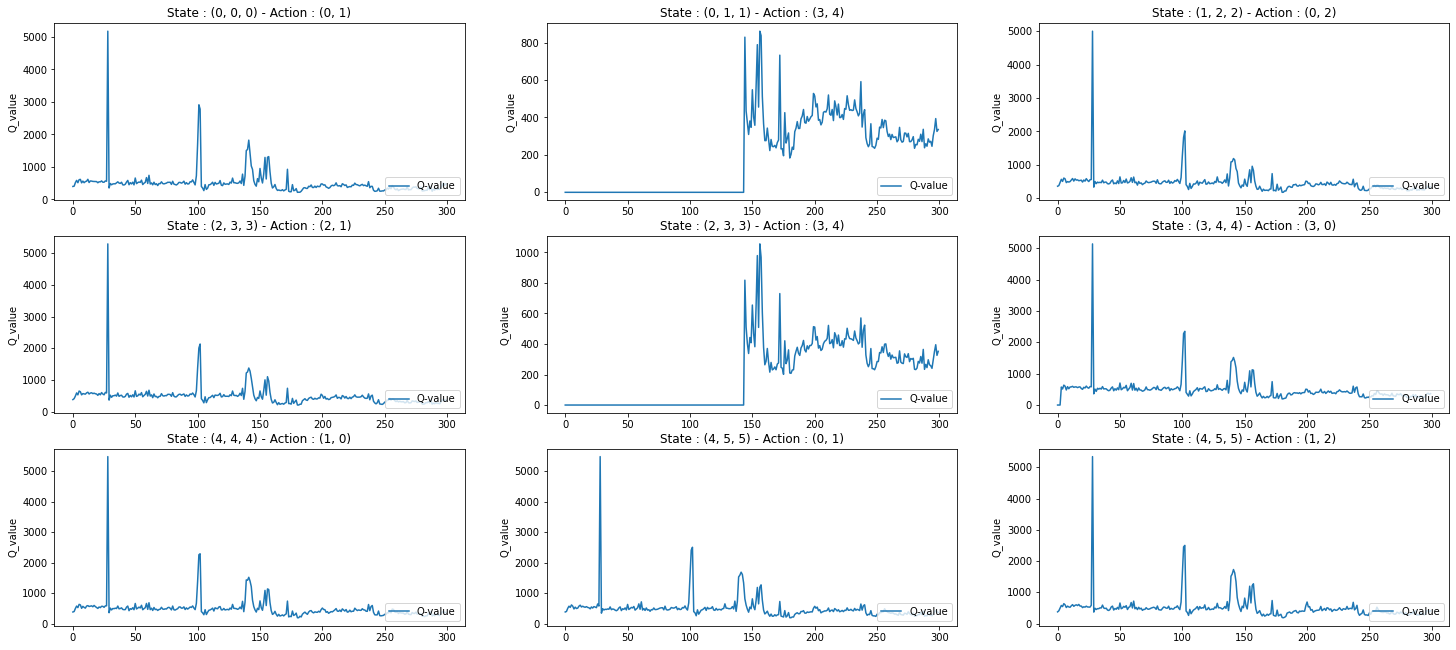

In [57]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_convergence(state, action)
    i +=1

**Observation** 
- The Q Value is steadily showing improvement spikes as the number of runs are increasing, which shows that the model is learning

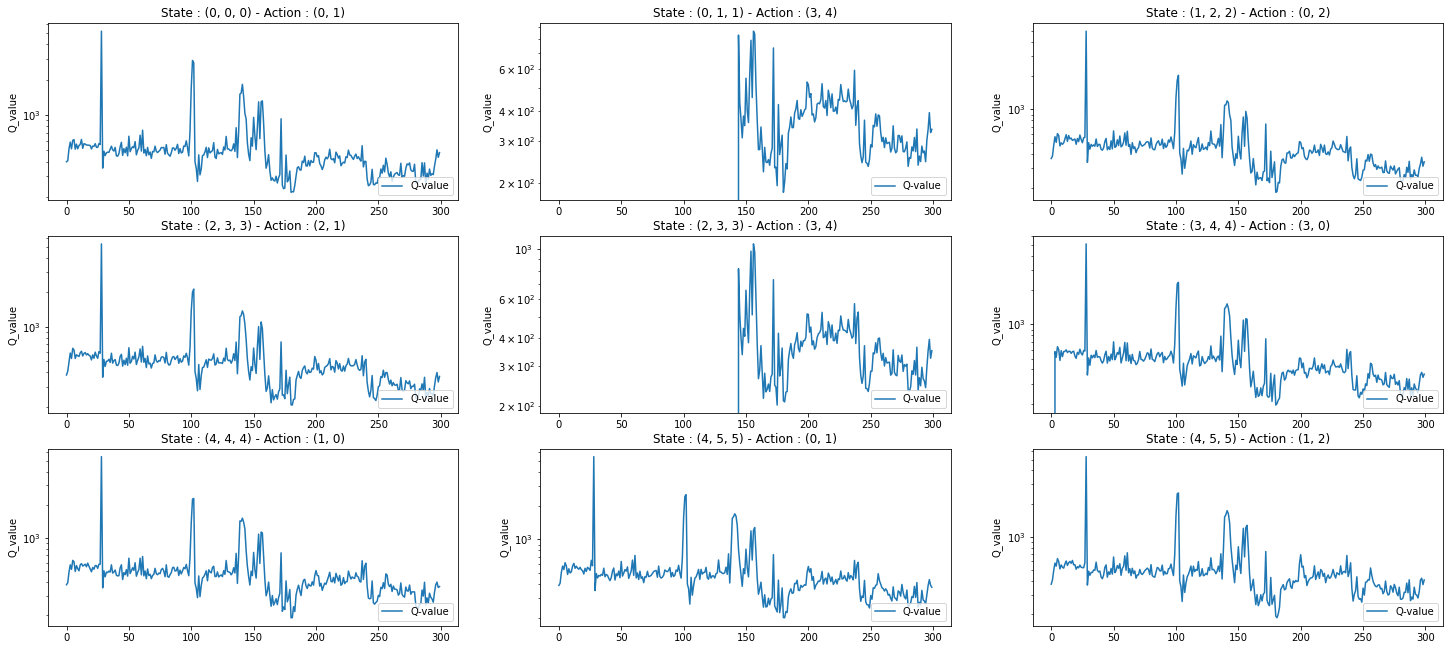

In [58]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_log_convergence(state, action)
    i +=1

**Observation** 
- The Log Scale is not that useful in smoothening the curve as the number of runs are restricted to 7000. 
- We can repeat the experiment with close to 15K runs and check for improvement of Q Values

**Plotting Average Monthly Rewards**

In [59]:
!cp model_weights.pkl '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/model_weights.pkl'

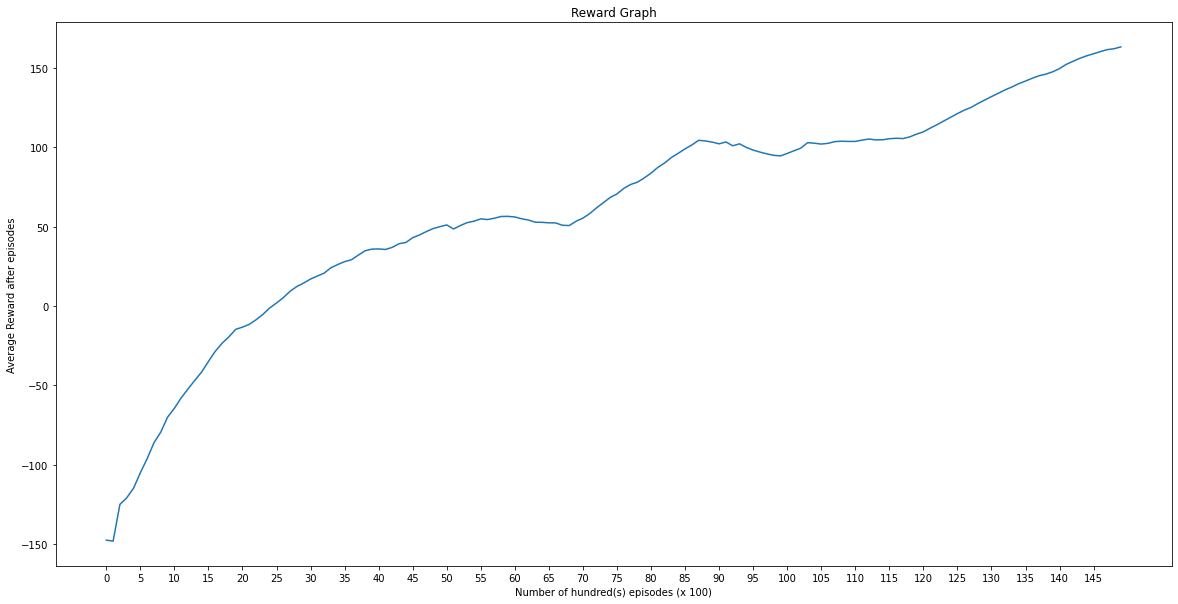

In [60]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 99])
    for x in range(0, total_episodes, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hundred(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()

**Conclusion**
- We have been able to create a Deep Q Model, which learns the Env and able to predict Actions, which can maximise the reward, which is the goal of this experiment
- As seen below, we start with a low Reward, and slowly the graph rises up to better rewards
- Having said that, we need to run many more iterations, to get to better results, which we havent done due to infrastructure and time constraints.